In [1]:
import os
import json
import time

import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from dataset import DPDataset
from model import return_2_fc, return_lstm, return_branch, CDPNet, combined_loss
from filehelp import make_file_name, show_series

In [2]:
PATH = '/home/rocky/IMLEARN/Saved'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

torch.Size([128, 3])
tensor([-0.9034,  0.3605,  0.7508], dtype=torch.float64)
tensor([-0.0000, -0.3095, -1.0496], dtype=torch.float64)
tensor([-0.0000,  0.4307, -6.4132], dtype=torch.float64)
tensor([-0.0000, -0.0428, -0.2844], dtype=torch.float64)
tensor([-0.0000,  0.0327, -0.6984], dtype=torch.float64)


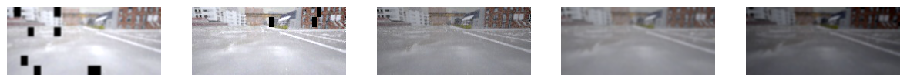

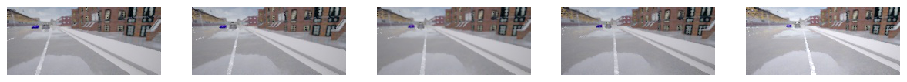

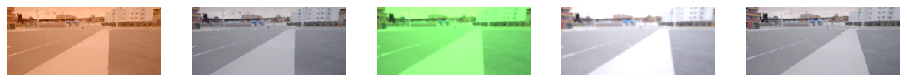

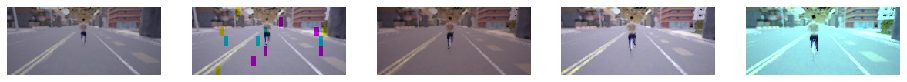

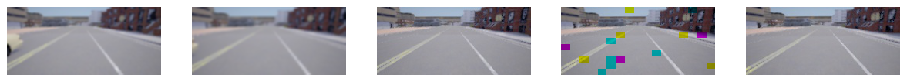

In [3]:
scales_dict =  {
    'car_vx':0.1,
    'dist_to_car':0.02,
    'dist_to_walker':0.02,
    'k':10,
    'headingerror':0.02,
    'cte':1
}

bs = 128

train_set = DPDataset(PATH, scales_dict=scales_dict,  seq_len=5, aug=True)
train_loader = DataLoader(train_set, batch_size=bs, shuffle=True)
iter_train = train_loader.__iter__()
X, y = next(iter_train)
print(y[1].shape)

#hist = plt.hist(y[1][:,0])

for i in range(5):
    print(y[1][i])
    show_series(X,i)

In [4]:
#dictionaries for parametrized network class
func_dict = {
    'cnn':torchvision.models.resnet18,
    'sensory':return_2_fc,
    'uncond':return_lstm,
    'main':return_lstm,
    'branch':return_branch
}

dims_dict = {
    'sensory_in':1,
    'sensory_hidden':64,
    'sensory_out':64,
    'cnn_out':128,
    'uncond_hidden':8,
    'uncond_nlayers':1,
    'uncond_out':3,
    'main_layers':1,
    'main_hidden':8,
    'branch_out':3,
    'branch_1':256,
    'branch_2':32
}
        
X, y = next(iter_train)     
X = [x.float() for x in X]
y = [x.float() for x in y]
model = CDPNet(func_dict, dims_dict)
with torch.no_grad():
    y_hat, hidden = model(X)

In [5]:
combined_loss(y_hat, y, X[2][:,-1,:])

(tensor(2.9013), tensor(1.1427), tensor(1.7586))

In [8]:
EPOCH = 5
BATCH_SIZE = 32
SEQ_LEN = 5
DEVICE = torch.device('cuda:0')
LR_INIT = 1e-4

train_set = DPDataset(PATH, scales_dict, seq_len=SEQ_LEN)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_set = DPDataset(PATH, scales_dict, seq_len=SEQ_LEN, val=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)
iter_val = val_loader.__iter__()

model = CDPNet(func_dict, dims_dict).to(DEVICE)
opt = torch.optim.RMSprop(model.parameters(), lr=LR_INIT)

e 0, b 0/1799, loss: 3.093, s_loss: 0.702, p_loss: 2.391, val loss: 3.100
e 0, b 50/1799, loss: 1.432, s_loss: 0.162, p_loss: 1.270, val loss: 2.005
e 0, b 100/1799, loss: 1.460, s_loss: 0.161, p_loss: 1.299, val loss: 0.864
e 0, b 150/1799, loss: 2.300, s_loss: 0.171, p_loss: 2.129, val loss: 0.979
e 0, b 200/1799, loss: 1.813, s_loss: 0.109, p_loss: 1.703, val loss: 0.229
e 0, b 250/1799, loss: 2.260, s_loss: 0.090, p_loss: 2.171, val loss: 1.242
e 0, b 300/1799, loss: 1.354, s_loss: 0.079, p_loss: 1.275, val loss: 1.653
e 0, b 350/1799, loss: 1.096, s_loss: 0.089, p_loss: 1.007, val loss: 4.394
e 0, b 400/1799, loss: 3.144, s_loss: 0.059, p_loss: 3.085, val loss: 0.177
e 0, b 450/1799, loss: 0.981, s_loss: 0.088, p_loss: 0.892, val loss: 0.636
e 0, b 500/1799, loss: 1.453, s_loss: 0.108, p_loss: 1.346, val loss: 0.219
e 0, b 550/1799, loss: 2.458, s_loss: 0.065, p_loss: 2.393, val loss: 0.282
e 0, b 600/1799, loss: 1.094, s_loss: 0.094, p_loss: 1.000, val loss: 1.530
e 0, b 650/1799

e 3, b 0/1799, loss: 1.299, s_loss: 0.071, p_loss: 1.227, val loss: 2.348
e 3, b 50/1799, loss: 1.624, s_loss: 0.069, p_loss: 1.555, val loss: 2.689
e 3, b 100/1799, loss: 1.238, s_loss: 0.050, p_loss: 1.188, val loss: 2.046
e 3, b 150/1799, loss: 0.433, s_loss: 0.046, p_loss: 0.387, val loss: 0.505
e 3, b 200/1799, loss: 0.496, s_loss: 0.040, p_loss: 0.456, val loss: 0.714
e 3, b 250/1799, loss: 0.380, s_loss: 0.038, p_loss: 0.342, val loss: 0.536
e 3, b 300/1799, loss: 0.470, s_loss: 0.039, p_loss: 0.431, val loss: 0.519
e 3, b 350/1799, loss: 0.438, s_loss: 0.048, p_loss: 0.391, val loss: 0.211
e 3, b 400/1799, loss: 0.762, s_loss: 0.059, p_loss: 0.703, val loss: 0.275
e 3, b 450/1799, loss: 0.380, s_loss: 0.048, p_loss: 0.332, val loss: 1.725
e 3, b 500/1799, loss: 1.327, s_loss: 0.059, p_loss: 1.268, val loss: 0.261
e 3, b 550/1799, loss: 0.509, s_loss: 0.058, p_loss: 0.451, val loss: 0.473
e 3, b 600/1799, loss: 0.459, s_loss: 0.041, p_loss: 0.418, val loss: 0.330
e 3, b 650/1799

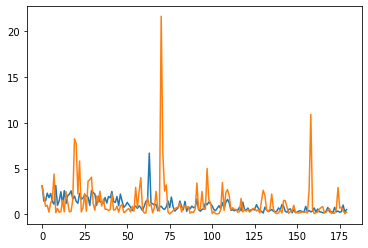

In [9]:
start = time.time()
train_loss_history = []
val_loss_history = []
val_freq = 50
save_freq = 100

total_batches = len(train_loader)
for e in range(EPOCH):
    for b, batch in enumerate(train_loader):
        X = batch[0]
        y = batch[1]
        X = [x.float().to(DEVICE) for x in X]
        y = [wy.float().to(DEVICE) for wy in y]
        
        pred, hidden_states = model(X)
        total_loss, s_loss, p_loss = combined_loss(pred, y, X[2][:,-1,:]) 
        
        total_loss.backward()
        opt.step()
        opt.zero_grad()
        
        if (b%val_freq==0):            
            model.eval()
            with torch.no_grad():
                X_val, y_val = next(iter_val)
                X_val = [x.float().to(DEVICE) for x in X_val]
                y_val = [wy.float().to(DEVICE) for wy in y_val]
                pred_val, hidden_states_val = model(X_val)
                
            loss_val = combined_loss(pred_val, y_val, X_val[2][:,-1,:])[0]
            
            val_loss_history.append(loss_val.item())
            train_loss_history.append(total_loss.item())
            
            print('e {}, b {}/{}, loss: {:.3f}, s_loss: {:.3f}, p_loss: {:.3f}, val loss: {:.3f}'.format(e, b, total_batches, total_loss, s_loss, p_loss, loss_val))
            
            model.train()
        
        
        #if b>=3:
            #break
            
plt.plot(train_loss_history)
plt.plot(val_loss_history)
print('Training took {} seconds'.format(time.time()-start))

In [40]:
test_set = DPDataset(PATH, scales_dict, seq_len=SEQ_LEN, val=True)
test_loader = DataLoader(test_set, batch_size=128)
iter_test = test_loader.__iter__()

for i in range(10):
    X, y = next(iter_test)
X = [x.float().to(DEVICE) for x in X]
y = [wy.float().to(DEVICE) for wy in y]

with torch.no_grad():
    pred, hidden_states = model(X)

Text(0.5, 0.98, 'Unconditional')

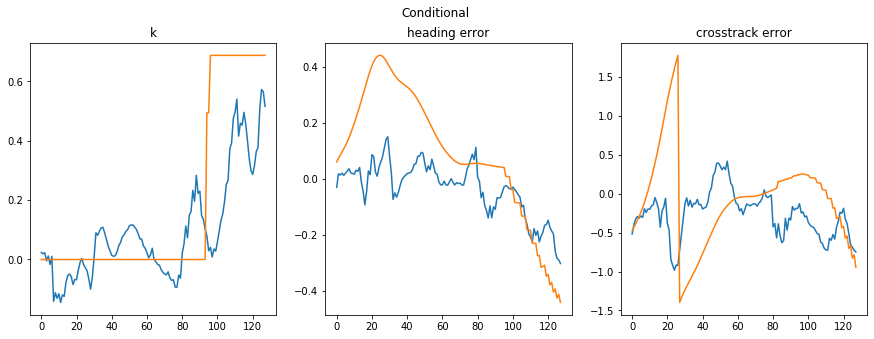

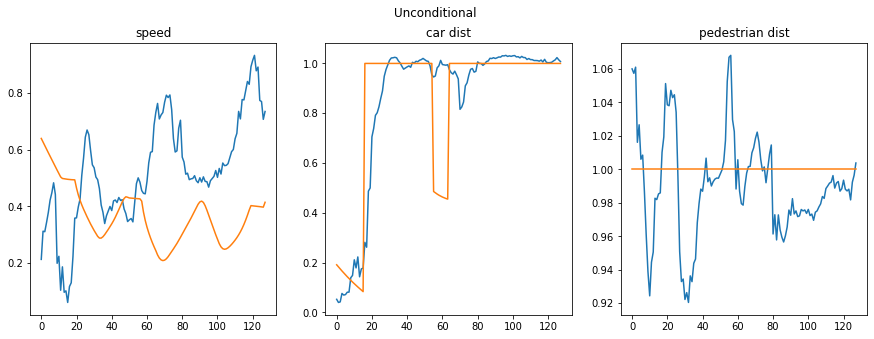

In [41]:
masked = pred[1]*torch.repeat_interleave(X[2][:,-1,:], repeats=3, dim=1)
masked = masked.view(-1, 5,3).sum(dim=1)

fig = plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(masked[:,0].cpu().detach())
plt.plot(y[1][:,0].cpu())
plt.title('k')
plt.subplot(1,3,2)
plt.plot(masked[:,1].cpu().detach())
plt.plot(y[1][:,1].cpu())
plt.title('heading error')
plt.subplot(1,3,3)
plt.plot(masked[:,2].cpu().detach())
plt.plot(y[1][:,2].cpu())
plt.title('crosstrack error')
plt.suptitle('Conditional')

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(pred[0][:,0].cpu())
plt.plot(y[0][:,0].cpu())
plt.title('speed')
plt.subplot(1,3,2)
plt.plot(pred[0][:,1].cpu())
plt.plot(y[0][:,1].cpu())
plt.title('car dist')
plt.subplot(1,3,3)
plt.plot(pred[0][:,2].cpu())
plt.plot(y[0][:,2].cpu())
plt.title('pedestrian dist')
plt.suptitle('Unconditional')